# Model Run English
Version 1.0  

Version 2.0
Added dropout layer. 

Version 3.0  
Lowered dimensionality. 

Version 4.0  
Changed ReLU to Tanh

Version 5.0  
Deleted resblock

Version 6.0  
Added back. Hiddim back to 3. 

Version 7.0  
This time using MF data. 

## Import Libs

In [1]:
import matplotlib.pyplot as plt
import os
import torch
from torch import optim
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
import pickle

from paths import *
# from model_config import *
from model_dataset import UngroundedSoundDataset, GroundedSoundDataset
# from model_model import *
from my_utils import get_timestamp
from misc_recorder import *
from misc_progress_bar import draw_progress_bar

## Localize Dirs

In [2]:
model_save_ = model_eng_save_dir

random_train_data_ = os.path.join(bsc_use_path, "phone_random_train.mfcc")
radnom_valid_data_ = os.path.join(bsc_use_path, "phone_random_validation.mfcc")
anno_test_data_ = os.path.join(bsc_use_path, "phone_anno_test.mfcc")

random_train_guide_ = os.path.join(bsc_use_path, "phone_random_train.csv")
random_valid_guide_ = os.path.join(bsc_use_path, "phone_random_validation.csv")
anno_test_guide_ = os.path.join(bsc_use_path, "phone_anno_test.csv")

## Configure READ

In [3]:
READ = False

In [4]:
BATCH_SIZE = 128
LOADER_WORKER = 0

FRAMES_IN_SEGMENT = 25

MFCC_DIM = 13
INPUT_DIM = FRAMES_IN_SEGMENT * MFCC_DIM * 3
OUTPUT_DIM = FRAMES_IN_SEGMENT * MFCC_DIM
# let's still maintain these interdims but just ignore them when building the model 
INTER_DIM_1 = 256
INTER_DIM_2 = 64
INTER_DIM_3 = 16
LATENT_DIM = 3

DROPOUT = 0.5

## Get Training Stamp

In [5]:
if READ: 
    ts = "1116223120"
else: 
    ts = str(get_timestamp())

train_name = "MFnoNorm"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
mk(model_save_dir)

stop_epoch = "32"
trainhist_name = "train.hst"
valhist_name = "val.hst"
valacc_name = "valacc.hst"
print(f"{train_name}-{ts}")

MFnoNorm-1120162406


## Prepare Loss Recording

In [6]:
train_losses = ListRecorder(os.path.join(model_save_dir, trainhist_name))
valid_losses = ListRecorder(os.path.join(model_save_dir, valhist_name))

valid_accs = ListRecorder(os.path.join(model_save_dir, valacc_name))

In [7]:
TYPE = "full"

In [8]:
train_ds = UngroundedSoundDataset(random_train_data_, random_train_guide_)
valid_ds = UngroundedSoundDataset(radnom_valid_data_, random_valid_guide_)

if TYPE == "part": 
    use_len = int(0.1 * len(train_ds))
    remain_len = len(train_ds) - use_len
    use_train_ds, remain_ds = random_split(train_ds, [use_len, remain_len])

    use_len = int(0.1 * len(valid_ds))
    remain_len = len(valid_ds) - use_len
    use_valid_ds, remain_ds = random_split(valid_ds, [use_len, remain_len])

    train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=LOADER_WORKER)
    train_num = len(train_loader.dataset)

    valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, 
                            shuffle=False, 
                            num_workers=LOADER_WORKER)
elif TYPE == "full": 
    use_train_ds = train_ds
    use_valid_ds = valid_ds
    
elif TYPE == "same":
    train_len = int(0.8 * len(train_ds))
    valid_len = len(train_ds) - train_len
    use_train_ds, use_valid_ds = random_split(train_ds, [train_len, valid_len])

train_loader = DataLoader(use_train_ds, batch_size=BATCH_SIZE, 
                        shuffle=True, 
                        num_workers=LOADER_WORKER)
train_num = len(train_loader.dataset)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=LOADER_WORKER)
valid_num = len(valid_loader.dataset)

1109614 1109614
163388 163388


In [9]:
train_num, valid_num

(1109614, 163388)

## Init Model

In [10]:
import torch.nn as nn
from model_config import *

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.lin1 = nn.Linear(n_chans, n_chans)
        self.lin2 = nn.Linear(n_chans, n_chans)
        self.batch_norm = nn.BatchNorm1d(num_features=n_chans)  # <5>
        self.dropout = nn.Dropout(p=DROPOUT)
        # self.relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.relu = nn.Tanh()

    def forward(self, x):
        out = self.batch_norm(x)
        out = self.relu(out)
        out = self.lin1(out)
        out = self.batch_norm(out)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.dropout(out)
        out = out + x
        return out

class LinPack(nn.Module):
    def __init__(self, n_in, n_out):
        super(LinPack, self).__init__()
        self.lin = nn.Linear(n_in, n_out)
        # self.relu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        # self.relu = nn.Tanh()
        self.batch_norm = nn.BatchNorm1d(num_features=n_out)
        self.dropout = nn.Dropout(p=DROPOUT)

    def forward(self, x):
        x = self.lin(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        return x


class ResAE(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, inter_dim1=INTER_DIM_1, inter_dim2=INTER_DIM_2, inter_dim3=INTER_DIM_3, latent_dim=LATENT_DIM, output_dim=OUTPUT_DIM):
        super(ResAE, self).__init__()

        self.encoder = nn.Sequential(
            LinPack(input_dim, inter_dim1), 
            # LinPack(inter_dim1, inter_dim3), 
            ResBlock(inter_dim1), 
            # ResBlock(inter_dim1), 
            nn.Linear(inter_dim1, latent_dim), 
            nn.Sigmoid()
        )

        self.decoder =  nn.Sequential(
            LinPack(latent_dim, inter_dim1), 
            # LinPack(inter_dim3, inter_dim1),
            ResBlock(inter_dim1), 
            # ResBlock(inter_dim1), 
            nn.Linear(inter_dim1, output_dim),
            # nn.Sigmoid(),
        )

        # initialize the weights
        self.encoder.apply(self.init_weights)
        self.decoder.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            # nn.init.xavier_uniform_(m.weight)
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            m.bias.data.fill_(0.01)

    def forward(self, x):
        org_size = x.size()
        y_size = (org_size[0], org_size[1], org_size[2] // 3)
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        recon_x = self.decoder(h).view(size=y_size)

        return recon_x
    
    def encode(self, x):
        org_size = x.size()
        y_size = (org_size[0], org_size[1], org_size[2] // 3)
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        return h

In [11]:
recon_loss = nn.MSELoss()
# recon_loss = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResAE(INPUT_DIM, INTER_DIM_1, INTER_DIM_2, INTER_DIM_3, LATENT_DIM, OUTPUT_DIM)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Define the file path and name
model_info_file = os.path.join(model_save_dir, 'model.txt')

# Open the file in write mode
with open(model_info_file, 'w') as f:
    f.write(str(model))
    f.write('\n\n')
    f.write(str(summary(model, input_size=(BATCH_SIZE, FRAMES_IN_SEGMENT, MFCC_DIM * 3))))
model

ResAE(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=975, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock(
      (lin1): Linear(in_features=256, out_features=256, bias=True)
      (lin2): Linear(in_features=256, out_features=256, bias=True)
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
      (relu): ReLU()
    )
    (2): Linear(in_features=256, out_features=3, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=3, out_features=256, bias=True)
      (relu): ReLU()
      (batch_norm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBloc

In [12]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

600392

## Load Model if READ

In [13]:
if READ: 
    valid_losses.read()
    train_losses.read()

    model_raw_name = f"{stop_epoch}"
    model_name = model_raw_name + ".pt"
    model_path = os.path.join(model_save_dir, model_name)
    state = torch.load(model_path)

    model.load_state_dict(state)
    model.to(device)

## Define Training

In [14]:
EPOCHS = 30
BASE = 0

In [15]:
def train(): 
    best_valid_loss = 1000000
    best_valid_loss_epoch = 0
    for epoch in range(BASE, BASE + EPOCHS):
        model.train()
        train_loss = 0.
        train_num = len(train_loader.dataset)    # train_loader
        for idx, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x)
            loss = recon_loss(x_hat, y)
            train_loss += loss.item()
            
            loss.backward()
            
            # torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            # 这个函数计算的是全局梯度范数
            # torch.nn.utils.clip_grad_norm(parameters=model.parameters(), max_norm=5, norm_type=2)
            # torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=5, norm_type=2)
            # parameters: an iterable of Variables that will have gradients normalized
            # max_norm: max norm of the gradients(阈值设定)
            # norm_type: type of the used p-norm. Can be'inf'for infinity norm(定义范数类型)

            optimizer.step()
            # scheduler.step()

            # draw_progress_bar(idx, train_num)

        train_losses.append(train_loss / train_num)

        last_model_name = f"{epoch}.pt"
        torch.save(model.state_dict(), os.path.join(model_save_dir, last_model_name))

        model.eval()
        valid_loss = 0.
        valid_num = len(valid_loader.dataset)
        for idx, (x, y) in enumerate(valid_loader):
            x = x.to(device)
            y = y.to(device)

            x_hat = model(x)
            loss = recon_loss(x_hat, y)
            valid_loss += loss.item()

            # draw_progress_bar(idx, valid_num)

        avg_valid_loss = valid_loss / valid_num
        valid_losses.append(avg_valid_loss)
        if avg_valid_loss < best_valid_loss: 
            best_valid_loss = avg_valid_loss
            best_valid_loss_epoch = epoch

        draw_learning_curve(losses=(train_losses.get(), valid_losses.get()), 
                            others=best_valid_loss_epoch, 
                            epoch=str(epoch))
        train_losses.save()
        valid_losses.save()

    return best_valid_loss_epoch

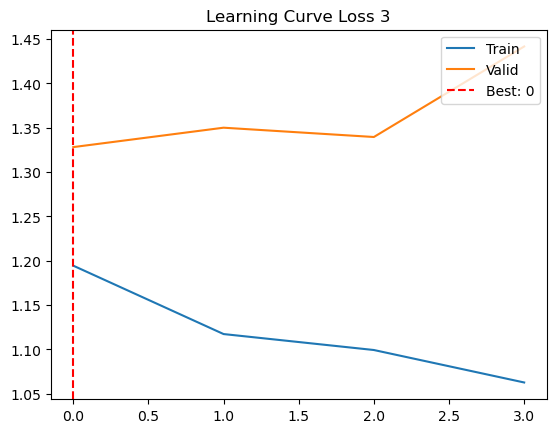

KeyboardInterrupt: 

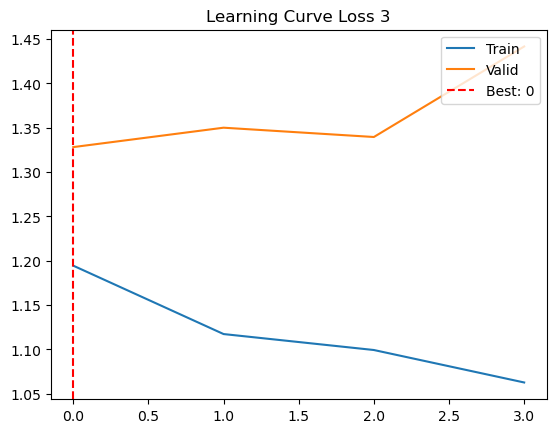

In [16]:
if __name__ == "__main__": 
    best_valid_loss_epoch = train()

In [19]:
def checkone(): 
    model.eval()
    valid_loss = 0.
    valid_num = len(valid_loader.dataset)
    for idx, (x, y) in enumerate(valid_loader):
        x = x.to(device)
        y = y.to(device)

        x_hat = model(x)
        return y, x_hat
        loss = recon_loss(x_hat, y)
        valid_loss += loss.item()

        # draw_progress_bar(idx, valid_num)

    avg_valid_loss = valid_loss / valid_num
    valid_losses.append(avg_valid_loss)

In [20]:
target, pred = checkone()

In [21]:
pred.shape

torch.Size([128, 25, 13])

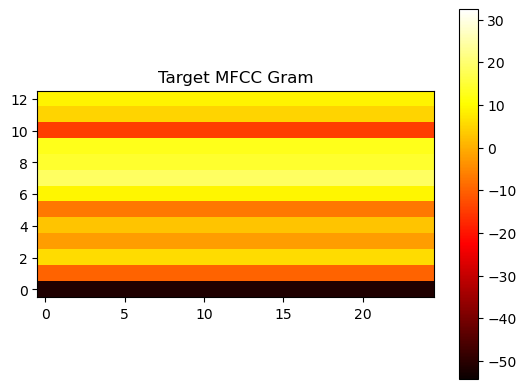

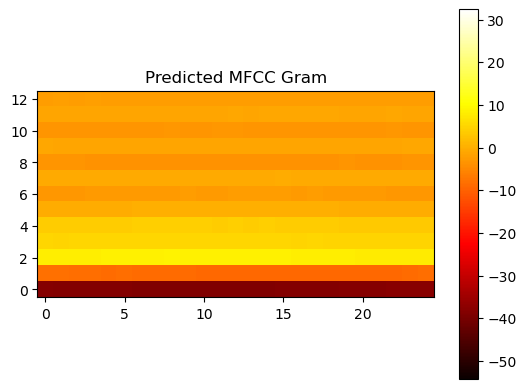

In [23]:
import matplotlib.pyplot as plt

# Calculate the minimum and maximum values of the MFCC grams
min_value = min(target[0].detach().cpu().numpy().min(), pred[0].detach().cpu().numpy().min())
max_value = max(target[0].detach().cpu().numpy().max(), pred[0].detach().cpu().numpy().max())

# Visualize the first MFCC gram
plt.imshow(target[2].detach().cpu().numpy().T, cmap='hot', origin='lower', vmin=min_value, vmax=max_value)
plt.title('Target MFCC Gram')
plt.colorbar()
plt.show()

# Visualize the second MFCC gram
plt.imshow(pred[2].detach().cpu().numpy().T, cmap='hot', origin='lower', vmin=min_value, vmax=max_value)
plt.title('Predicted MFCC Gram')
plt.colorbar()
plt.show()


In [19]:
gsds = GroundedSoundDataset(anno_data_, anno_guide_test_)
eval_loader = DataLoader(gsds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER)

In [23]:
stop_epoch = "59"
model_raw_name = f"{stop_epoch}"
model_name = model_raw_name + ".pt"
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

ResAE(
  (encoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=975, out_features=64, bias=True)
      (relu): Tanh()
    )
    (1): ResBlock(
      (lin1): Linear(in_features=64, out_features=64, bias=True)
      (lin2): Linear(in_features=64, out_features=64, bias=True)
      (relu): Tanh()
    )
    (2): Linear(in_features=64, out_features=3, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): LinPack(
      (lin): Linear(in_features=3, out_features=64, bias=True)
      (relu): Tanh()
    )
    (1): ResBlock(
      (lin1): Linear(in_features=64, out_features=64, bias=True)
      (lin2): Linear(in_features=64, out_features=64, bias=True)
      (relu): Tanh()
    )
    (2): Linear(in_features=64, out_features=325, bias=True)
  )
)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
hiddens = None
tags = None
model.eval()
with torch.no_grad():
    for idx, (s, e, t) in enumerate(eval_loader):
        s = s.to(device)
        hidden = model.encode(s)
        hidden = hidden.cpu().data.numpy()

        if hiddens is not None: 
            hiddens = np.concatenate((hiddens, hidden), axis=0)
            tags = np.concatenate((tags, t), axis=0)
        else: 
            hiddens = hidden
            tags = t
num_phones = np.unique(tags).shape[0]
kmeansmodel = KMeans(n_clusters=num_phones) # , random_state=0
clusters = kmeansmodel.fit_predict(hiddens)
np.save(model_save_dir + "_hc.npy", clusters)
np.save(model_save_dir + "_hr.npy", hiddens)

/home/ldlmdl/anaconda3/envs/featln/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [30]:
h, c, v = homogeneity_completeness_v_measure(tags, clusters)

In [31]:
h, c, v

(0.005978210035328847, 0.005086944667294446, 0.005496682961327691)